In [1]:
#!python -m pip install "numpy<2.0" --upgrade


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("dataset/data_total_final_t0t1.csv")

In [5]:
# According to VIF, we found multicolinearity problem in 
# total_elapsed_time and total_session_completed
# so filter thease features
data = data[['days_used', 'cv_daily_elapsed_time', 'cv_interval',
            'lcs_score_sum', 'stress_total', 'education', 'age',
            'relationship', 'pre_meditation_frequency', 'gender',
            'race', 'wellbeing_t0_m', 'wellbeing_t1_m']]

## Dimensionality Reduction

In [7]:
data['education'] = data['education'].replace({"advanced_degree":"college_or_higher",
                                                             "bachelors_degree":"college_or_higher",
                                                            "some_college_or_associates":"college_or_higher",
                                                            "high_school":"lower_than_college",
                                                            "some_high_school":"lower_than_college",
                                                            "middle_school":"lower_than_college",
                                                            "primary_school":"lower_than_college",
                                                            "none":"lower_than_college"})

data['age'] = data['age'].replace({"75_or_older":"55-",
                                                 "65-74":"55-",
                                                 "35-44":"35-54",
                                                 "25-34":"18-34",
                                                 "55-64":"55-",
                                                 "45-54":"35-54",
                                                 "19-24":"18-34",
                                                 "55-64":"55-",
                                                 "18-24":"18-34"
                                                })

data['relationship'] = data['relationship'].replace({"married_domestic_part":"has_partner",
                                                                  "single_never_married":"no_partner",
                                                                  "committed":"has_partner",
                                                                  "divorced":"no_partner",
                                                                  "separated":"no_partner",
                                                                  "widowed":"no_partner"})

data['pre_meditation_frequency'] = data['pre_meditation_frequency'].replace({"didnt_meditate":"no_exp",
                                                                                          "less_than_once":"no_exp",
                                                                                          "1-2":"exp",
                                                                                          "3-4":"exp",
                                                                                          "5-6":"exp",
                                                                                          "7_or_more":"exp"})
data['gender'] = data['gender'].replace({"female":"female",
                                         "male":"male",
                                         "fluid_nonbinary":"other"})

data['race'] = data['race'].replace({"asian":"other",
                                     "white":"white",
                                     "hisp_latin_span":"other",
                                     "mid_east_north_afr":"other",
                                     "black_afr_amer":"other",
                                     "am_indian_ak_native":"other",
                                     "nat_hi_pac_isl":"other",
                                     "perfer_not_to_say": "other"})

data = data.rename(columns = {"pre_meditation_frequency" : "med_exp"})

## Cleaning Missing Data

In [13]:
# filter the rows where have NA value in dependent variable(wellbeing_t1_m)
data = data[data['wellbeing_t1_m'].notnull()]

In [15]:
missing_ratio = data.isnull().mean() * 100
print(missing_ratio.sort_values(ascending=False))

race                     20.764421
gender                   20.577854
med_exp                  20.325736
age                      20.320694
education                20.315651
relationship             20.315651
cv_interval              19.266841
cv_daily_elapsed_time    15.409439
wellbeing_t0_m            1.079064
lcs_score_sum             0.050424
days_used                 0.000000
stress_total              0.000000
wellbeing_t1_m            0.000000
dtype: float64


In [17]:
data.shape

(19832, 13)

In [19]:
# Function for descriptive stats
def cat_summary(df, col):
    # Missing count & ratio
    total = len(df)
    missing_count = df[col].isna().sum()
    missing_ratio = missing_count / total
    # value counts
    counts = df[col].value_counts(dropna=True)
    ratios = counts / total

    summary_df = pd.DataFrame({
        'count' : counts,
        'ratio' : ratios,
    })

    # Append missing info
    summary_df.loc['missing'] = [missing_count, missing_ratio]
    
    return summary_df

def con_summary(df, col):
    series = df[col]
    total_n = len(series)

    # statistic excluding NA
    n = series.notna().sum()
    mean = series.mean(skipna=True)
    sd = series.std(skipna=True)

    # missing info
    missing_n = series.isna().sum()
    missing_ratio = missing_n / total_n

    # result
    result = pd.Series({
    'n' : n,
    'mean' : mean,
    'sd' : sd,
    'missing_n' : missing_n,
    'missing_ratio' : missing_ratio}, name = col)

    return result

In [127]:
con_summary(data, 'lcs_score_sum')

n                19822.000000
mean                 0.674270
sd                   0.704476
missing_n           10.000000
missing_ratio        0.000504
Name: lcs_score_sum, dtype: float64

## Train_test Split

In [21]:
# split datsets into helidin/heldout set
from sklearn.model_selection import train_test_split
X = data.drop(['wellbeing_t1_m'], axis='columns')
y = data['wellbeing_t1_m']
X_heldin, X_heldout, y_heldin, y_heldout = train_test_split(X,y,test_size=0.2, random_state = 112)

In [23]:
# split heldin datsets into train, valid sets
X_train, X_valid, y_train, y_valid = train_test_split(X_heldin,y_heldin, test_size=0.2, random_state = 113)

In [25]:
print(X_train.shape)
print(X_valid.shape)
print(X_heldout.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_heldout.shape)

(12692, 12)
(3173, 12)
(3967, 12)
(12692,)
(3173,)
(3967,)


## Multiple Imputation(MICE)

In [27]:
import miceforest as mf

In [29]:
for col in X_train:
    if X_train[col].dtypes == 'object':
        X_train[col] = X_train[col].astype("category")

for col in X_valid:
    if X_valid[col].dtypes == 'object':
        X_valid[col] = X_valid[col].astype("category")

In [31]:
X_train_fix = X_train.reset_index(drop=True).copy()
y_train_fix = y_train.reset_index(drop=True).copy()

In [33]:
kernel = mf.ImputationKernel(
    data = X_train_fix,
    num_datasets=10,
    save_all_iterations_data=True,
    random_state = 1,
    mean_match_candidates=0)

In [37]:
kernel.mice(iterations=5, verbose = True)

Initialized logger with name MICE Iterations 1 - 5 and 4 levels
1 Dataset 0
 | race | gender | med_exp | education | age | relationship | cv_interval | cv_daily_elapsed_time | wellbeing_t0_m | lcs_score_sum
Dataset 1
 | race | gender | med_exp | education | age | relationship | cv_interval | cv_daily_elapsed_time | wellbeing_t0_m | lcs_score_sum
Dataset 2
 | race | gender | med_exp | education | age | relationship | cv_interval | cv_daily_elapsed_time | wellbeing_t0_m | lcs_score_sum
Dataset 3
 | race | gender | med_exp | education | age | relationship | cv_interval | cv_daily_elapsed_time | wellbeing_t0_m | lcs_score_sum
Dataset 4
 | race | gender | med_exp | education | age | relationship | cv_interval | cv_daily_elapsed_time | wellbeing_t0_m | lcs_score_sum
Dataset 5
 | race | gender | med_exp | education | age | relationship | cv_interval | cv_daily_elapsed_time | wellbeing_t0_m | lcs_score_sum
Dataset 6
 | race | gender | med_exp | education | age | relationship | cv_interval | cv

In [39]:
X_train_imp = [kernel.complete_data(dataset=i) for i in range(10)]

In [41]:
for i in range(10):
    print((X_train_imp[i].index == y_train_fix.index).all())

True
True
True
True
True
True
True
True
True
True


In [43]:
# Make 1 Imputed validation set
X_valid_fix=X_valid.reset_index(drop=True).copy()
y_valid_fix=y_valid.reset_index(drop=True).copy()

X_valid_imp = kernel.impute_new_data(X_valid_fix).complete_data(0)
X_valid_imp = pd.DataFrame(X_valid_imp, columns=X_valid_fix.columns, index=X_valid_fix.index)

In [153]:
print((X_valid_imp.index == y_valid_fix.index).all())

True


## One hot encoding

In [45]:
cat_columns = ['education', 'age', 'relationship', 'med_exp', 'gender', 'race']

# train set
for i in range(10):
    # one hot encoding for categorical variables
    X_train_imp[i] = pd.get_dummies(data=X_train_imp[i], columns = cat_columns, drop_first = True)
    
    for col in X_train_imp[i].columns:
        if X_train_imp[i][col].dtypes == 'bool':
            X_train_imp[i][col] = X_train_imp[i][col].astype(int)

# validation set
X_valid_imp = pd.get_dummies(data=X_valid_imp, columns = cat_columns, drop_first = True)
for col in X_valid_imp:
    if X_valid_imp[col].dtypes == 'bool':
        X_valid_imp[col] = X_valid_imp[col].astype(int)

## Standard Scaling

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score

scaling_column = ['wellbeing_t0_m', 
                 'days_used', 'cv_daily_elapsed_time',
                 'cv_interval', 'lcs_score_sum', 'stress_total']
X_train_imp_scaled = []
scalers = []

# train set
for i in range(10):
    scaler = StandardScaler()
    Xt = X_train_imp[i].copy()
    Xt[scaling_column] = scaler.fit_transform(Xt[scaling_column])
    X_train_imp_scaled.append(Xt)
    scalers.append(scaler)

# validation set
X_valid_imp_scaled = X_valid_imp.copy()
X_valid_imp_scaled[scaling_column] = scaler.transform(X_valid_imp_scaled[scaling_column])

## 4. Fit the Model (KNN)

In [51]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from pandas.api.types import is_bool_dtype

In [71]:
knn = KNeighborsRegressor()
pipe = Pipeline([('knn', knn)])
k_values = list(range(1,200))
param_grid = {'knn__n_neighbors':k_values}
full_cv_regressor = GridSearchCV(pipe, param_grid, cv=5, scoring = 'neg_root_mean_squared_error')

In [73]:
knn_matrix = []

for i in range(10):

    # Full Cross Validation Grid Search for finding best K-value
    full_cv_regressor.fit(X_train_imp_scaled[i], y_train_fix)
    best_k_value = full_cv_regressor.best_params_['knn__n_neighbors']

    # Create KNN model and fit the model
    knn_model = KNeighborsRegressor(n_neighbors = best_k_value)
    knn_model.fit(X_train_imp_scaled[i], y_train_fix)
    knn_y_preds = knn_model.predict(X_valid_imp_scaled)

    # Performance metrics (validation set)
    rmse = root_mean_squared_error(y_valid_fix, knn_y_preds)
    r2 = r2_score(y_valid_fix, knn_y_preds)
    knn_matrix.append({'imputation':i, 'k_values':best_k_value, 'rmse':round(rmse,4), 'r2':round(r2, 4)})

In [75]:
knn_matrix

[{'imputation': 0, 'k_values': 47, 'rmse': 1.5122, 'r2': 0.5094},
 {'imputation': 1, 'k_values': 46, 'rmse': 1.5107, 'r2': 0.5104},
 {'imputation': 2, 'k_values': 48, 'rmse': 1.512, 'r2': 0.5095},
 {'imputation': 3, 'k_values': 53, 'rmse': 1.5132, 'r2': 0.5088},
 {'imputation': 4, 'k_values': 48, 'rmse': 1.5124, 'r2': 0.5093},
 {'imputation': 5, 'k_values': 47, 'rmse': 1.5109, 'r2': 0.5102},
 {'imputation': 6, 'k_values': 52, 'rmse': 1.5116, 'r2': 0.5098},
 {'imputation': 7, 'k_values': 53, 'rmse': 1.5136, 'r2': 0.5085},
 {'imputation': 8, 'k_values': 52, 'rmse': 1.5139, 'r2': 0.5083},
 {'imputation': 9, 'k_values': 45, 'rmse': 1.5098, 'r2': 0.5109}]

In [83]:
knn_matrix_total = []
avg_rmse = sum(knn_matrix[i]['rmse'] for i in range(10))/10
avg_r2 = sum(knn_matrix[i]['r2'] for i in range(10))/10
knn_matrix_total.append({'avg_rmse':avg_rmse, 'avg_r2':avg_r2})
knn_matrix_total

[{'avg_rmse': 1.51203, 'avg_r2': 0.5095099999999999}]

In [77]:
## KNN graph

valid_error_rates_rmse = []
valid_error_rates_r2 = []


for k in range(1,100):
    knn_model = KNeighborsRegressor(n_neighbors = k)
    knn_model.fit(X_train_imp_scaled[9], y_train_fix)
    knn_y_preds = knn_model.predict(X_valid_imp_scaled)
    rmse = root_mean_squared_error(y_valid_fix, knn_y_preds)
    r2 = r2_score(y_valid_fix, knn_y_preds)
    valid_error_rates_rmse.append(rmse)
    valid_error_rates_r2.append(r2)

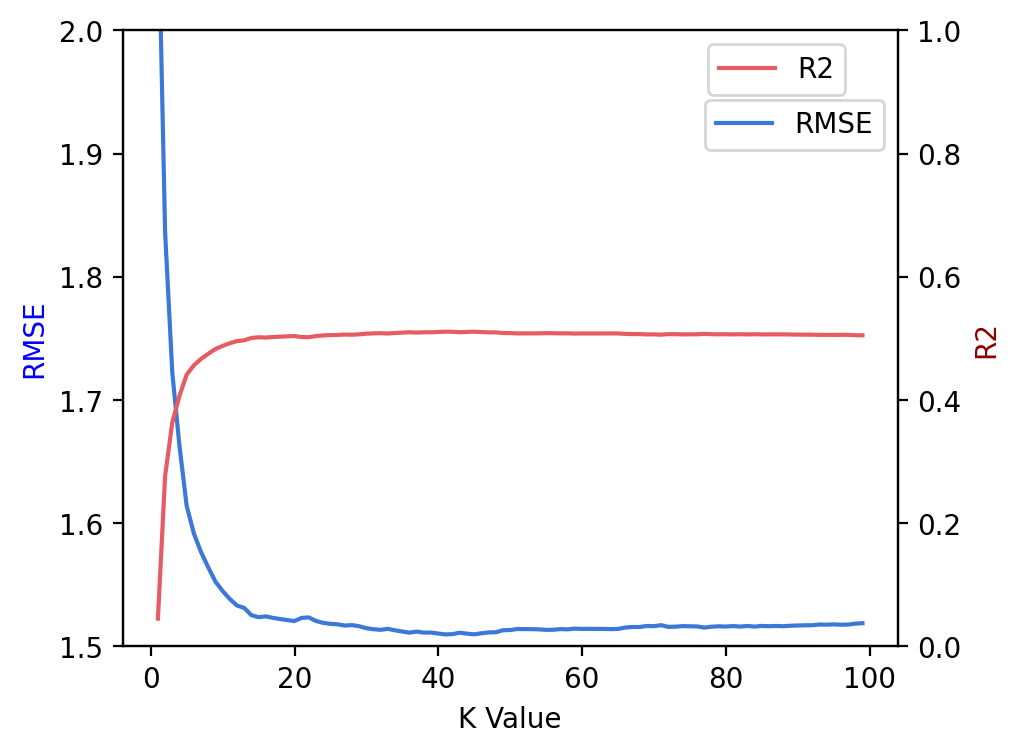

In [79]:
fig, ax1 = plt.subplots(figsize=(5,4),dpi=200)
plt.plot(range(1,100),valid_error_rates_rmse,label='RMSE', color = '#3c78d8')
plt.legend(loc = 'upper right', bbox_to_anchor = (1, 0.91))
plt.xlabel("K Value")
ax1.set_ylim(1.5,2.0)
ax1.set_ylabel('RMSE')

ax2 = ax1.twinx()
plt.plot(range(1,100),valid_error_rates_r2,label='R2', color = '#e65c63')
ax2.set_ylabel('R2')
ax2.set_ylim(0,1.0)
ax2.legend(loc='upper right', bbox_to_anchor = (0.95, 1))

ax1.yaxis.label.set_color('blue')
ax2.yaxis.label.set_color('darkred')

plt.show()

In [81]:
knn_matrix

[{'imputation': 0, 'k_values': 47, 'rmse': 1.5122, 'r2': 0.5094},
 {'imputation': 1, 'k_values': 46, 'rmse': 1.5107, 'r2': 0.5104},
 {'imputation': 2, 'k_values': 48, 'rmse': 1.512, 'r2': 0.5095},
 {'imputation': 3, 'k_values': 53, 'rmse': 1.5132, 'r2': 0.5088},
 {'imputation': 4, 'k_values': 48, 'rmse': 1.5124, 'r2': 0.5093},
 {'imputation': 5, 'k_values': 47, 'rmse': 1.5109, 'r2': 0.5102},
 {'imputation': 6, 'k_values': 52, 'rmse': 1.5116, 'r2': 0.5098},
 {'imputation': 7, 'k_values': 53, 'rmse': 1.5136, 'r2': 0.5085},
 {'imputation': 8, 'k_values': 52, 'rmse': 1.5139, 'r2': 0.5083},
 {'imputation': 9, 'k_values': 45, 'rmse': 1.5098, 'r2': 0.5109}]

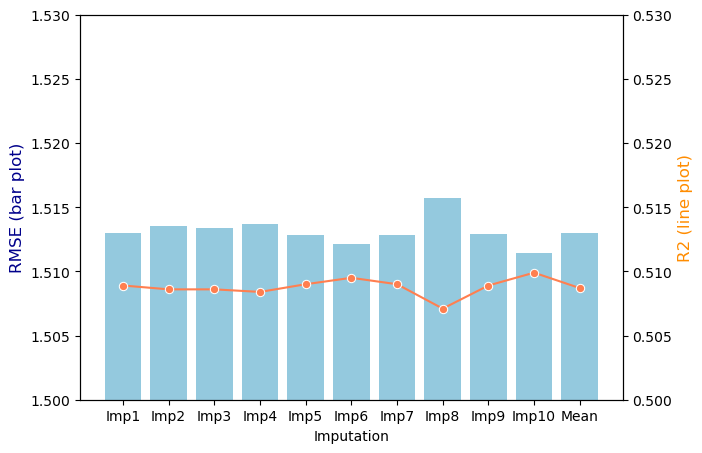

In [113]:
# bar plot
knn_bar_data = pd.DataFrame({
    'Imp': ['Imp1', 'Imp2', 'Imp3', 'Imp4', 'Imp5', 'Imp6', 'Imp7',
            'Imp8', 'Imp9', 'Imp10', 'Mean'],
    'RMSE': [1.513, 1.5135, 1.5134, 1.5137, 1.5128, 1.5121, 1.5128, 
             1.5157, 1.5129, 1.5114, 1.513],
    'R2': [0.5089, 0.5086, 0.5086, 0.5084, 0.509, 0.5095, 0.509,
          0.5071, 0.5089, 0.5099, 0.5087]})

fig, ax1 = plt.subplots(figsize = (7,5))

sns.barplot(x='Imp', y='RMSE', data=knn_bar_data, ax=ax1, color = 'skyblue')
ax1.set_xlabel('Imputation')
ax1.set_ylabel('RMSE (bar plot)', fontsize = 12, color = 'darkblue')
ax1.set_ylim(1.50, 1.53)

ax2 = ax1.twinx()
sns.lineplot(x='Imp', y='R2', data = knn_bar_data, ax=ax2,
             color = 'coral', marker = 'o')
ax2.set_ylabel('R2 (line plot)', fontsize=12, color = 'darkorange')
ax2.set_ylim(0.50, 0.53)
             
plt.show()

## 5. Fit the Model (RF)

In [53]:
from sklearn.ensemble import RandomForestRegressor

In [117]:
rf_matrix_total = []

In [155]:
rf_matrix = []

n_estimators = [3000]
max_features = ["sqrt"]
param_grid_rf = {"n_estimators": n_estimators, "max_features":max_features}

rfc = RandomForestRegressor(random_state = 111, n_jobs = -1, bootstrap = True)
grid = GridSearchCV(rfc, param_grid_rf)

for i in range(10):
    grid.fit(X_train_imp[i], y_train_fix)
    best_est = grid.best_params_['n_estimators']
    best_feature = grid.best_params_['max_features']

    # Create model with best parameters and fit it
    rf_model = RandomForestRegressor(n_estimators = best_est, max_features = best_feature, random_state = 118,
                                     n_jobs = -1, bootstrap = True)
    rf_model.fit(X_train_imp[i], y_train_fix)
    rf_y_preds = rf_model.predict(X_valid_imp)

    # Performance metrics(validation set)
    rf_rmse = root_mean_squared_error(y_valid_fix, rf_y_preds)
    r2 = r2_score(y_valid_fix, rf_y_preds)
    rf_matrix.append({'imputation':i, 'n_estimators':best_est, 'max_features':best_feature,
                      'rmse': rf_rmse, 'r2':r2})

In [157]:
# average rmse and r2 across imputed datasets
avg_rmse = sum(rf_matrix[i]['rmse'] for i in range(10))/10
avg_r2 = sum(rf_matrix[i]['r2'] for i in range(10))/10
rf_matrix_total.append({'trees':n_estimators[0], 'avg_rmse':avg_rmse, 'avg_r2':avg_r2})

In [151]:
rf_matrix

[{'imputation': 0,
  'n_estimators': 2500,
  'max_features': 'sqrt',
  'rmse': 1.4939470020372845,
  'r2': 0.5211724889879928},
 {'imputation': 1,
  'n_estimators': 2500,
  'max_features': 'sqrt',
  'rmse': 1.4917779510095683,
  'r2': 0.5225618921388675},
 {'imputation': 2,
  'n_estimators': 2500,
  'max_features': 'sqrt',
  'rmse': 1.49383752780668,
  'r2': 0.5212426619629182},
 {'imputation': 3,
  'n_estimators': 2500,
  'max_features': 'sqrt',
  'rmse': 1.495814805308653,
  'r2': 0.5199744348761395},
 {'imputation': 4,
  'n_estimators': 2500,
  'max_features': 'sqrt',
  'rmse': 1.4932360354460081,
  'r2': 0.5216281267820537},
 {'imputation': 5,
  'n_estimators': 2500,
  'max_features': 'sqrt',
  'rmse': 1.4909655441542582,
  'r2': 0.523081766260169},
 {'imputation': 6,
  'n_estimators': 2500,
  'max_features': 'sqrt',
  'rmse': 1.4926121348687764,
  'r2': 0.5220277878276409},
 {'imputation': 7,
  'n_estimators': 2500,
  'max_features': 'sqrt',
  'rmse': 1.4966474328450052,
  'r2': 0

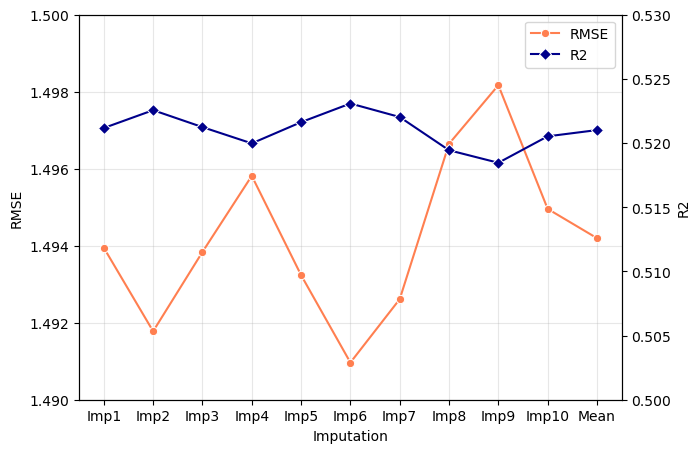

In [183]:
# line graph
# data
rf_line_graph = pd.DataFrame({
    'Imp': ['Imp1', 'Imp2', 'Imp3', 'Imp4', 'Imp5', 'Imp6', 'Imp7',
            'Imp8', 'Imp9', 'Imp10', 'Mean'],
    'RMSE': [1.4939470020372845, 1.4917779510095683, 1.49383752780668,
             1.495814805308653, 1.4932360354460081, 1.4909655441542582,
             1.4926121348687764, 1.4966474328450052, 1.498168985173275,
             1.494956650343269, 1.494196406899278],
    'R2': [0.5211724889879928, 0.5225618921388675, 0.5212426619629182,
           0.5199744348761395, 0.5216281267820537, 0.523081766260169,
           0.5220277878276409, 0.5194398850889407, 0.5184622746937719,
           0.520525062074104, 0.5210116380692599]})
    

# ax1 (RMSE)
fig, ax1 = plt.subplots(figsize = (7,5))
plt.xlabel('Imputation')
sns.lineplot(x='Imp', y='RMSE', data = rf_line_graph, ax=ax1,
             color = 'coral', marker = 'o', label='RMSE')
ax1.set_ylabel('RMSE')
ax1.set_ylim(1.49,1.50)
plt.grid(True, alpha=.3)

# ax2(R2)
ax2 = ax1.twinx()
sns.lineplot(x='Imp', y='R2', data = rf_line_graph, ax=ax2,
             color = 'darkblue', marker = 'D', label= 'R2', legend=False)
ax2.set_ylabel('R2')
ax2.set_ylim(0.50,0.53)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines1+lines2,
    labels1+labels2,
    loc = 'upper right')

plt.show()

In [159]:
rf_matrix_total
# n_estimaotrs = 1000 would be enough, we can see convergence of rmse and r2

[{'trees': 500, 'avg_rmse': 1.4956666550292086, 'avg_r2': 0.520067609162991},
 {'trees': 1000, 'avg_rmse': 1.4948300586485321, 'avg_r2': 0.5206049188696278},
 {'trees': 1500, 'avg_rmse': 1.494396080148428, 'avg_r2': 0.5208834412959997},
 {'trees': 2000, 'avg_rmse': 1.494257443934832, 'avg_r2': 0.5209725005242845},
 {'trees': 2500, 'avg_rmse': 1.494196406899278, 'avg_r2': 0.5210116380692599},
 {'trees': 3000, 'avg_rmse': 1.4940790552185574, 'avg_r2': 0.5210868660963147}]

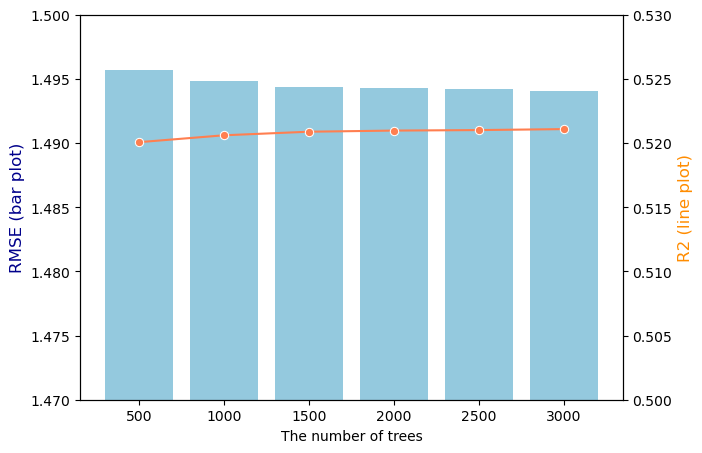

In [163]:
rf_bar_data = pd.DataFrame({
    'Trees': ['500', '1000', '1500', '2000', '2500', '3000'],
    'avg_RMSE': [
    1.4956666550292086,
    1.4948300586485321,
    1.494396080148428,
    1.494257443934832,
    1.494196406899278,
    1.4940790552185574
],
    'avg_R2': [
    0.520067609162991,
    0.5206049188696278,
    0.5208834412959997,
    0.5209725005242845,
    0.5210116380692599,
    0.5210868660963147
]})

fig, ax1 = plt.subplots(figsize = (7,5))

sns.barplot(x='Trees', y='avg_RMSE', data=rf_bar_data, ax=ax1, color = 'skyblue')
ax1.set_xlabel('The number of trees')
ax1.set_ylabel('RMSE (bar plot)', fontsize = 12, color = 'darkblue')
ax1.set_ylim(1.47, 1.50)

ax2 = ax1.twinx()
sns.lineplot(x='Trees', y='avg_R2', data = rf_bar_data, ax=ax2,
             color = 'coral', marker = 'o')
ax2.set_ylabel('R2 (line plot)', fontsize=12, color = 'darkorange')
ax2.set_ylim(0.50, 0.53)
             
plt.show()

In [ ]:
sns.lineplot(x='Imputation', y='R2', hue='Model', style = 'Model',
             data=data_r2_long, ax=ax2, palette = 'Set2', markers=True,
             dashes = False,legend=False)
ax2.set_ylim(0.45, 0.55)
ax2.set_ylabel("R2")

## 5. Fit the Model (MLP)

In [55]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

torch: 2.8.0



In [57]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import time

In [205]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# transform dataset to Tensor

# X_train
X_train_tensor = []

for i in range(10):
    X_np = X_train_imp_scaled[i].to_numpy(dtype = np.float32)
    X_tensor = torch.tensor(X_np, dtype=torch.float32, device=DEVICE)
    X_train_tensor.append(X_tensor)

# X_valid
X_valid_np = X_valid_imp_scaled.to_numpy(dtype=np.float32)
X_valid_tensor = torch.tensor(X_valid_np, dtype = torch.float32, device =DEVICE)

# y_train/y_valid
y_train_np = y_train_fix.to_numpy(dtype=np.int64)
y_valid_np = y_valid_fix.to_numpy(dtype=np.int64)
y_train_tensor = torch.tensor(y_train_np, dtype = torch.float32, device = DEVICE)
y_valid_tensor = torch.tensor(y_valid_np, dtype = torch.float32, device = DEVICE)

In [207]:
print(X_train_tensor[0].shape)
print(X_valid_tensor.shape)
print(y_train_tensor.shape)
print(y_valid_tensor.shape)

torch.Size([12692, 20])
torch.Size([3173, 20])
torch.Size([12692])
torch.Size([3173])


In [247]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 247
BATCH_SIZE = 200
NUM_HIDDEN_1 = 50
NUM_HIDDEN_2 = 30
DROP_PROBA = 0.2
NUM_EPOCHS = 1000
LEARNING_RATE = 0.001

In [249]:
## Modeling
class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, drop_proba, 
                 num_hidden_1, num_hidden_2, out_features = 1):
        super(MultilayerPerceptron, self).__init__()

        self.my_network = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, num_hidden_1, bias=False),
            #torch.nn.BatchNorm1d(num_hidden_1),
            #torch.nn.LeakyReLU(),
            torch.nn.Dropout(drop_proba),
            # 2nd hidden layer
            torch.nn.Linear(num_hidden_1, num_hidden_2, bias=False),
            #torch.nn.BatchNorm1d(num_hidden_2),
            #torch.nn.LeakyReLU(),
            torch.nn.Dropout(drop_proba),
            # Ouput layer
            torch.nn.Linear(num_hidden_2, out_features)
        )

    def forward(self,x):
        preds = self.my_network(x)
        return preds

In [251]:
# Model Initialization
torch.manual_seed(RANDOM_SEED)
model = MultilayerPerceptron(num_features = 20,
                             drop_proba = DROP_PROBA,
                             num_hidden_1 = NUM_HIDDEN_1,
                             num_hidden_2 = NUM_HIDDEN_2
                             )
model = model.to(DEVICE)

#optimizer = torch.optim.SGD(model.parameters(), 
#                            lr = LEARNING_RATE,
#                            momentum = 0.9,
#                            nesterov = True,
#                            weight_decay = 0.0001
#                           )
optimizer = torch.optim.Adam(model.parameters(), 
                            lr = LEARNING_RATE)

In [253]:
epoch_cost_train = []
epoch_cost_valid = []
epoch_r2_train = []
epoch_r2_valid = []
minibatch_cost = []

i = 5

for epoch in range(NUM_EPOCHS):
    model.train()

    X_train_i = X_train_tensor[i].to(DEVICE).float()
    y_train_i = y_train_tensor.to(DEVICE).float().view(-1,1)

    n_samples = X_train_i.shape[0]
    batch_size = BATCH_SIZE

    perm = torch.randperm(n_samples, device=DEVICE)
    X_train_i = X_train_i[perm]
    y_train_i = y_train_i[perm]

    #minibatch#
    batch_idx = 0
    for start in range(0, n_samples, batch_size):
        end = min(start+batch_size, n_samples)
        features = X_train_i[start:end]
        targets = y_train_i[start:end]

        optimizer.zero_grad()
        preds = model(features)
        loss = F.mse_loss(preds, targets)
        loss.backward()
        optimizer.step()

        minibatch_cost.append((epoch, batch_idx, loss.item()))
        batch_idx += 1


    # evalation of epoch (train/valid)
    model.eval()
    with torch.no_grad():
        # Train MSE
        pred_tr = model(X_train_i)
        train_mse = F.mse_loss(pred_tr, y_train_i).item()
        epoch_cost_train.append(train_mse)
        # train R^2
        ss_total = torch.sum((y_train_i - y_train_i.mean())**2)
        ss_res = torch.sum((y_train_i - pred_tr)**2)
        train_r2 = 1 - ss_res/ss_total
        epoch_r2_train.append(train_r2)

        # valid MSE
        X_valid = X_valid_tensor.to(DEVICE).float()
        y_valid = y_valid_tensor.to(DEVICE).float().view(-1,1)
        pred_valid = model(X_valid)
        valid_mse = F.mse_loss(pred_valid, y_valid).item()
        epoch_cost_valid.append(valid_mse)
        # valid R^2
        ss_total = torch.sum((y_valid - y_valid.mean())**2)
        ss_res = torch.sum((y_valid - pred_valid)**2)
        valid_r2 = 1 - ss_res/ss_total
        epoch_r2_valid.append(valid_r2)

print(f'Epoch {epoch+1:03d}/{NUM_EPOCHS:03d} | Train RMSE: {np.sqrt(train_mse):.4f} | Valid RMSE: {np.sqrt(valid_mse):.4f} | Valid_r2:{valid_r2:.4f}')

Epoch 10000/10000 | Train RMSE: 1.5027 | Valid RMSE: 1.4985 | Valid_r2:0.5257


In [ ]:
# (imp 0)  Train RMSE: 1.5052 | Valid RMSE: 1.4973 | Valid_r2:0.5265
# (imp 1) Train RMSE: 1.5046 | Valid RMSE: 1.4967 | Valid_r2:0.5269
# (imp 2)  Train RMSE: 1.5044 | Valid RMSE: 1.4988 | Valid_r2:0.5255
# (imp 3)  Train RMSE: 1.5048 | Valid RMSE: 1.4990 | Valid_r2:0.5254
# (imp 4)  Train RMSE: 1.5052 | Valid RMSE: 1.4982 | Valid_r2:0.5259
# (imp 5)  Train RMSE: 1.5037 | Valid RMSE: 1.4990 | Valid_r2:0.5254
# (imp 6)  Train RMSE: 1.5038 | Valid RMSE: 1.5000 | Valid_r2:0.5248
# (imp 7)  Train RMSE: 1.5048 | Valid RMSE: 1.4988 | Valid_r2:0.5255
# (imp 8) Train RMSE: 1.5058 | Valid RMSE: 1.4976 | Valid_r2:0.5263
# (imp 9) Train RMSE: 1.5061 | Valid RMSE: 1.4989 | Valid_r2:0.5255 

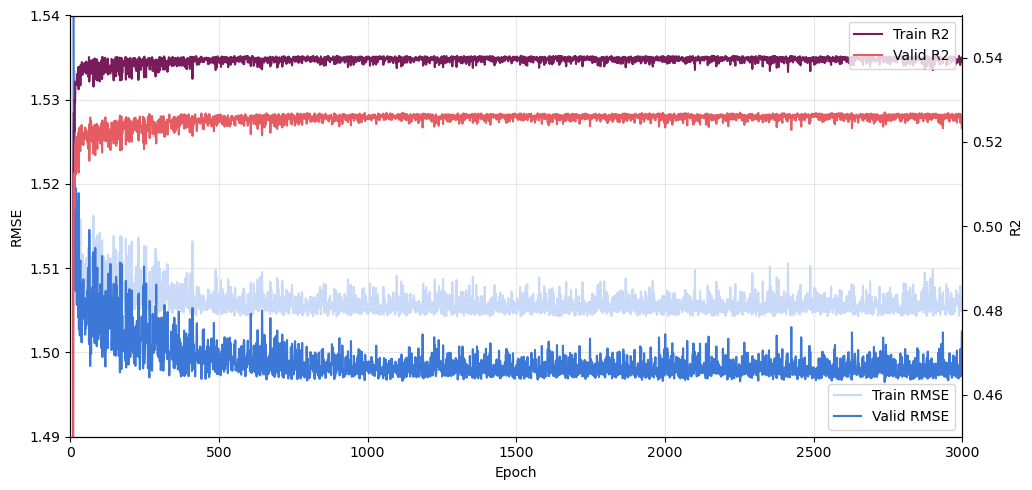

In [209]:
## 합친 버전

train_rmse = [np.sqrt(float(c)) for c in epoch_cost_train]
valid_rmse = [np.sqrt(float(c)) for c in epoch_cost_valid]
train_r2 = [float(c) for c in epoch_r2_train]
valid_r2 = [float(c) for c in epoch_r2_valid]
epochs = range(1, 3001)

# ax1 (RMSE)
fig, ax1 = plt.subplots(figsize=(10,5))
plt.plot(epochs, train_rmse, label = 'Train RMSE', color = '#c9daf8')
plt.plot(epochs, valid_rmse, label = 'Valid RMSE', color = '#3c78d8')
plt.xlabel('Epoch')
ax1.set_ylabel('RMSE')
ax1.set_ylim(1.49,1.54)
plt.xlim(0,3000)
ax1.legend(loc='lower right')
plt.grid(True, alpha=.3)
plt.tight_layout()

# ax2(R2)
ax2 = ax1.twinx()
plt.plot(epochs, train_r2, label = 'Train R2', color = '#781c5b')
plt.plot(epochs, valid_r2, label = 'Valid R2', color = '#e65c63')
ax2.set_ylabel('R2')
ax2.set_ylim(0.45,0.55)
ax2.legend(loc='upper right')

plt.show()

plt.savefig("mlp_curves.pdf", format = "pdf", bbox_inches = "tight")
plt.close()

## 6. Refitting with whole held-in dataset

In [59]:
held_in_X = pd.concat([X_train_imp[0], X_valid_imp], axis=0, ignore_index =True)
held_in_y = pd.concat([y_train_fix, y_valid_fix], axis=0, ignore_index=True)

## 7. Applying Multiple imputation into the held-out dataset

In [61]:
for col in X_heldout:
    if X_heldout[col].dtypes == 'object':
        X_heldout[col] = X_heldout[col].astype("category")

In [63]:
# apply MICE to the held-out dataset
X_heldout_fix=X_heldout.reset_index(drop=True).copy()
y_heldout_fix=y_heldout.reset_index(drop=True).copy()

X_heldout_imp = kernel.impute_new_data(X_heldout_fix).complete_data(0)
X_heldout_imp = pd.DataFrame(X_heldout_imp, columns=X_heldout_fix.columns, index=X_heldout_fix.index)

In [217]:
print((X_heldout_imp.index == y_heldout_fix.index).all())

True


In [65]:
cat_columns = ['education', 'age', 'relationship', 'med_exp', 'gender', 'race']

# held-out set dummy coding
X_heldout_imp = pd.get_dummies(data=X_heldout_imp, columns = cat_columns, drop_first = True)
for col in X_heldout_imp:
    if X_heldout_imp[col].dtypes == 'bool':
        X_heldout_imp[col] = X_heldout_imp[col].astype(int)

In [67]:
X_heldout_imp.sample(3)

,days_used,cv_daily_elapsed_time,cv_interval,lcs_score_sum,stress_total,wellbeing_t0_m,education_lower_than_college,education_prefer_not_to_say,age_35-54,age_55-,age_prefer_not_to_say,relationship_no_partner,relationship_prefer_not_to_say,med_exp_no_exp,med_exp_prefer_not_to_say,gender_male,gender_other,gender_prefer_not_to_say,race_prefer_not_to_say,race_white
1919,1,0.662035,1.979539,0.041667,26,9.333333,0,0,1,0,0,0,0,1,0,0,0,0,0,1
3676,25,0.346782,1.347570,2.555147,31,11.583333,0,0,0,0,0,0,0,1,0,0,0,0,0,1
628,22,0.433698,1.398564,0.755853,16,13.166667,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [87]:
held_in_X_scaled = held_in_X.copy()
held_in_X_scaled[scaling_column] = scaler.transform(held_in_X_scaled[scaling_column])

X_heldout_imp_scaled = X_heldout_imp.copy()
X_heldout_imp_scaled[scaling_column] = scaler.transform(X_heldout_imp_scaled[scaling_column])

## 8. Predict RF model with heldin/heldout imputed data

In [85]:
rf_best_model = RandomForestRegressor(n_estimators = 2500, max_features = 'sqrt', random_state = 121, n_jobs = -1, bootstrap = True)
rf_best_model.fit(held_in_X, held_in_y)
rf_best_pred = rf_best_model.predict(X_heldout_imp)
best_rf_rmse = root_mean_squared_error(y_heldout_fix, rf_best_pred)
best_rf_r2 = r2_score(y_heldout_fix, rf_best_pred)

print(f"RMSE:{best_rf_rmse}, R2:{best_rf_r2}")

RMSE:1.5115502561022531, R2:0.530883908471675


## 9. Predict KNN model with heldin/heldout imputed data

In [89]:
knn_best_model = KNeighborsRegressor(n_neighbors = 45)
knn_best_model.fit(held_in_X_scaled, held_in_y)
knn_best_pred = knn_best_model.predict(X_heldout_imp_scaled)
best_knn_rmse = root_mean_squared_error(y_heldout_fix, knn_best_pred)
best_knn_r2 = r2_score(y_heldout_fix, knn_best_pred)

print(f"RMSE:{best_knn_rmse}, R2:{best_knn_r2}")

RMSE:1.5442725258300716, R2:0.5103530678128729


## 9. Compare with basic regression model

In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV

In [197]:
# Fit simple regression model across all imputed datasets
rg_total = []
rg_matrix = []

for i in range(10):

    # Create KNN model and fit the model
    reg_model = LinearRegression()
    reg_model.fit(X_train_imp_scaled[i], y_train_fix)
    reg_y_preds = reg_model.predict(X_valid_imp_scaled)

    # Performance metrics (validation set)
    rmse = root_mean_squared_error(y_valid_fix, reg_y_preds)
    r2 = r2_score(y_valid_fix, reg_y_preds)
    rg_matrix.append({'imputation':i, 'rmse':round(rmse,4), 'r2':round(r2, 4)})
    
# average rmse and r2 across imputed datasets
avg_rmse = sum(rg_matrix[i]['rmse'] for i in range(10))/10
avg_r2 = sum(rg_matrix[i]['r2'] for i in range(10))/10
rg_total.append({'avg_rmse':avg_rmse, 'avg_r2':avg_r2})

In [233]:
rg_total

[{'avg_rmse': 1.472, 'avg_r2': 0.53514}]

In [93]:
reg_model = LinearRegression()
reg_model.fit(held_in_X_scaled, held_in_y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [95]:
test_predictions = reg_model.predict(X_heldout_imp_scaled)
rg_rmse = root_mean_squared_error(y_heldout_fix, test_predictions)
rg_r2 = r2_score(y_heldout_fix, test_predictions)

In [97]:
print(f"RMSE: {rg_rmse}, R^2: {rg_r2}")

RMSE: 1.4715444008947656, R^2: 0.5553872741275563


In [275]:
# Elastic Net

elastic_model = ElasticNetCV(l1_ratio = [.1, .5, .7,.9, .95, .99, 1],tol=0.01)
elastic_model.fit(held_in_X_scaled, held_in_y)

,l1_ratio,"[0.1, 0.5, ...]"
,eps,0.001
,n_alphas,'deprecated'
,alphas,'warn'
,fit_intercept,True
,precompute,'auto'
,max_iter,1000
,tol,0.01
,cv,None
,copy_X,True
,verbose,0


In [277]:
test_predictions = elastic_model.predict(X_heldout_imp_scaled)
rg_rmse = root_mean_squared_error(y_heldout_fix, test_predictions)
rg_r2 = r2_score(y_heldout_fix, test_predictions)
print(f"RMSE: {rg_rmse}, R^2: {rg_r2}")

RMSE: 1.4715116448084247, R^2: 0.5554070677684899


## Refitting/evaluation of the MLP model

In [252]:
## tensor

# held_in_X_scaled
held_in_X_scaled = held_in_X_scaled.to_numpy(dtype = np.float32)
X_heldin_tensor = torch.tensor(held_in_X_scaled, dtype = torch.float32, device = DEVICE)

# X_heldout_imp_scaled
X_heldout_imp_scaled = X_heldout_imp_scaled.to_numpy(dtype = np.float32)
X_heldout_tensor = torch.tensor(X_heldout_imp_scaled, dtype = torch.float32, device = DEVICE)

# held_in_y
held_in_y= held_in_y.to_numpy(dtype = np.float32)
y_heldin_tensor = torch.tensor(held_in_y, dtype = torch.float32, device = DEVICE)

# y_heldout_fix
held_out_y = y_heldout_fix.to_numpy(dtype = np.float32)
y_heldout_tensor = torch.tensor(held_out_y, dtype = torch.float32, device = DEVICE)

In [254]:
## Modeling
class best_MLP(torch.nn.Module):

    def __init__(self, num_features, drop_proba, 
                 num_hidden_1, num_hidden_2, out_features = 1):
        super(best_MLP, self).__init__()

        self.my_network = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, num_hidden_1, bias=False),
            torch.nn.BatchNorm1d(num_hidden_1),
            #torch.nn.LeakyReLU(),
            torch.nn.Dropout(drop_proba),
            # 2nd hidden layer
            torch.nn.Linear(num_hidden_1, num_hidden_2, bias=False),
            torch.nn.BatchNorm1d(num_hidden_2),
            #torch.nn.LeakyReLU(),
            torch.nn.Dropout(drop_proba),
            # Ouput layer
            torch.nn.Linear(num_hidden_2, out_features)
        )

    def forward(self,x):
        preds = self.my_network(x)
        return preds

## Model Initialization
torch.manual_seed(112)
best_model = best_MLP(num_features = 19,
                 drop_proba = 0.2,
                 num_hidden_1 = 50,
                 num_hidden_2 = 30)
best_model = best_model.to(DEVICE)
optimizer = torch.optim.Adam(best_model.parameters(), lr = 0.001)


## Model fitting
epoch_cost_train = []
epoch_cost_test = []
minibatch_cost = []

for epoch in range(1000):
    best_model.train()

    X_train_i = X_heldin_tensor.to(DEVICE).float()
    y_train_i = y_heldin_tensor.to(DEVICE).float().view(-1,1)

    n_samples = X_train_i.shape[0]
    batch_size = 200

    perm = torch.randperm(n_samples, device=DEVICE)
    X_train_i = X_train_i[perm]
    y_train_i = y_train_i[perm]
    
    #minibatch#
    batch_idx = 0
    for start in range(0, n_samples, batch_size):
        end = min(start+batch_size, n_samples)
        features = X_train_i[start:end]
        targets = y_train_i[start:end]

        optimizer.zero_grad()
        preds = best_model(features)
        loss = F.mse_loss(preds, targets)
        loss.backward()
        optimizer.step()

        minibatch_cost.append((epoch, batch_idx, loss.item()))
        batch_idx += 1

    # evalation of epoch (train/test)
    best_model.eval()
    with torch.no_grad():
        # Train RMSE
        pred_tr = best_model(X_train_i)
        train_mse = F.mse_loss(pred_tr, y_train_i).item()
        epoch_cost_train.append(np.sqrt(train_mse))

        # test RMSE
        X_test = X_heldout_tensor.to(DEVICE).float()
        y_test = y_heldout_tensor.to(DEVICE).float().view(-1,1)
        pred_test = best_model(X_test)
        test_mse = F.mse_loss(pred_test, y_test).item()
        epoch_cost_test.append(np.sqrt(test_mse))

        # test R^2
        ss_tot_test = torch.sum((y_test - y_valid.mean())**2)
        ss_res_test = torch.sum((y_test - pred_test)**2)
        test_r2 = 1 - ss_res_test/ss_tot_test
    
print(
    f'Epoch {epoch+1:03d}/{NUM_EPOCHS:03d} |' 
    f'Train RMSE: {np.sqrt(train_mse):.4f} |' 
    f'Test RMSE: {np.sqrt(test_mse):.4f} |'
    f'Test R^2: {test_r2:.4f} |')

Epoch 1000/1000 |Train RMSE: 1.4739 |Test RMSE: 1.4721 |Test R^2: 0.5731 |


/var/folders/pn/l6kb96rs7vz20qcp8gnx23nw0000gn/T/ipykernel_58662/2404200634.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=final_compare_data, ax=ax1, palette = 'crest')


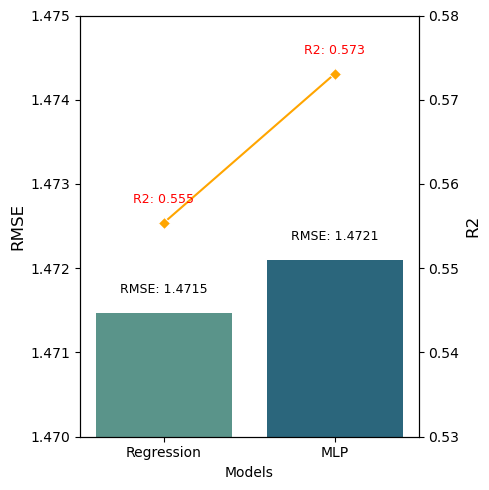

In [331]:
## compare simple regreesion vs mlp model
final_compare_data = pd.DataFrame({
    'Model': ['Regression', 'MLP'],
    'RMSE': [1.4714653473885786, 1.4721],
    'R2': [0.5554070677684899, 0.5731]})
sns.color_palette("crest", as_cmap=True)

fig, ax1 = plt.subplots(figsize = (5,5))

sns.barplot(x='Model', y='RMSE', data=final_compare_data, ax=ax1, palette = 'crest')
ax1.set_xlabel('Models')
ax1.set_ylabel('RMSE', fontsize = 12, color = 'black')
ax1.set_ylim(1.47, 1.475)

for p in ax1.patches:
    height = p.get_height()
    ax1.text(
        p.get_x() + p.get_width()/2,
        height + 0.0002,                # 살짝 위에
        f'RMSE: {height:.4f}',                # 소수점 4자리
        ha='center', va='bottom',
        color='black', fontsize=9
    )

ax2 = ax1.twinx()
sns.lineplot(x='Model', y='R2', data = final_compare_data, ax=ax2,
             color = 'orange', marker = 'D')
ax2.set_ylabel('R2', fontsize=12, color = 'black')
ax2.set_ylim(0.53, 0.58)

# line 점 위에 값 쓰기
line = ax2.lines[0]
x_data = line.get_xdata()
y_data = line.get_ydata()

for x, y in zip(x_data, y_data):
    ax2.text(
        x,
        y + 0.002,                       # 점보다 조금 위
        f'R2: {y:.3f}',                      # 소수점 3자리
        ha='center', va='bottom',
        color='red', fontsize=9
    )

# Change axis and tick colors to match the data plots
#ax1.yaxis.label.set_color('darkblue')
#ax2.yaxis.label.set_color('darkorange')
#ax1.tick_params(axis='y', colors='blue')
#ax2.tick_params(axis='y', colors='darkorange')

plt.tight_layout()
             
plt.show()

## 9. Feature Importance
### also this will be useful for visualization of RF model.

In [263]:
from sklearn.inspection import permutation_importance
feature_names = X_heldout_imp.columns

start_time = time.time()
result = permutation_importance(rf_best_model, X_heldout_imp, y_heldout_fix,
                                n_repeats=10, random_state=112, n_jobs = 2,
                               scoring = 'neg_root_mean_squared_error')
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances_std = pd.Series(result.importances_std, index=feature_names)

Elapsed time to compute the importances: 421.705 seconds


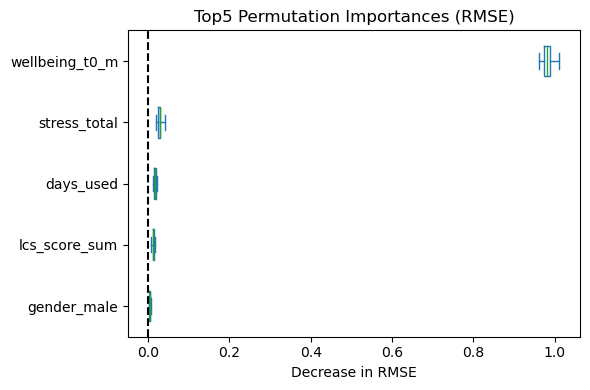

In [267]:
sorted_importances_idx = result.importances_mean.argsort()[::-1]
top5_idx = sorted_importances_idx[:5]

importances = pd.DataFrame(
    result.importances[top5_idx].T,
    columns=X_heldout_imp.columns[top5_idx],
)

ax = importances.plot.box(vert=False, whis=10, figsize = (6,4))
ax.set_title("Top5 Permutation Importances (RMSE)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in RMSE")
ax.invert_yaxis()
ax.figure.tight_layout()

plt.show()

In [152]:
start_time = time.time()
result = permutation_importance(rf_best_model, X_heldout_imp, y_heldout_fix,
                                n_repeats=10, random_state=112, n_jobs = 2,
                               scoring = 'r2')
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances_std = pd.Series(result.importances_std, index=feature_names)

NameError: name 'permutation_importance' is not defined

In [150]:
sorted_importances_idx = result.importances_mean.argsort()[::-1]
top5_idx = sorted_importances_idx[:5]

importances = pd.DataFrame(
    result.importances[top5_idx].T,
    columns=X_heldout_imp.columns[top5_idx],
)

ax = importances.plot.box(vert=False, whis=10, figsize = (6,4))
ax.set_title("Top5 Permutation Importances (R^2)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in R^2")
ax.invert_yaxis()
ax.figure.tight_layout()

plt.show()

NameError: name 'result' is not defined

## Visualization

In [360]:
models = ["KNN", "RF", "MLP"]
metrics = ["RMSE", "R^2"]

cols = pd.MultiIndex.from_product(
    [models, metrics],
    names = ["Model", "Metric"]
)

index = [f"Imp{i}" for i in range(1,11)]

df_vis = pd.DataFrame(index=index, columns=cols, dtype=float)

In [376]:
df_vis[("MLP", "RMSE")] = [1.4973, 1.4967, 1.4988, 1.4990, 1.4982, 1.4990, 1.5000, 1.4988, 1.4976, 1.4989]
df_vis[("MLP", "R^2")] = [0.5265, 0.5269, 0.5255, 0.5254, 0.5259, 0.5254, 0.5248, 0.5255, 0.5263, 0.5255]
df_vis[("RF", "RMSE")] = [round(rf_matrix[i]['rmse'], 4) for i in range(10)]
df_vis[("RF", "R^2")] = [round(rf_matrix[i]['r2'], 4) for i in range(10)]
df_vis[("KNN", "RMSE")] = [round(knn_matrix[i]['rmse'], 4) for i in range(10)]
df_vis[("KNN", "R^2")] = [round(knn_matrix[i]['r2'], 4) for i in range(10)]

In [424]:
mean_row = df_vis.mean(axis=0)
df_vis.loc["Mean"] = mean_row

In [426]:
df_vis

Model       KNN                RF               MLP         
Metric     RMSE      R^2     RMSE      R^2     RMSE      R^2
Imp1    1.52770  0.49930  1.49360  0.52140  1.49730  0.52650
Imp2    1.52220  0.50290  1.49240  0.52220  1.49670  0.52690
Imp3    1.52080  0.50380  1.49370  0.52130  1.49880  0.52550
Imp4    1.53110  0.49700  1.49610  0.51980  1.49900  0.52540
Imp5    1.52300  0.50240  1.49340  0.52150  1.49820  0.52590
Imp6    1.52310  0.50230  1.49080  0.52320  1.49900  0.52540
Imp7    1.52280  0.50250  1.49240  0.52220  1.50000  0.52480
Imp8    1.52400  0.50170  1.49620  0.51970  1.49880  0.52550
Imp9    1.52300  0.50240  1.49820  0.51840  1.49760  0.52630
Imp10   1.52580  0.50050  1.49570  0.52010  1.49890  0.52550
Mean    1.52435  0.50148  1.49425  0.52098  1.49843  0.52577

In [746]:
latex_table = df_vis.to_latex(
    buf = None,
    index = True,
    multicolumn = True,
    multirow = True,
    float_format = "%.4f",
    caption = "Model Performance Comparison",
    label = "tab:model_performance")
print(latex_table)

\begin{table}
\caption{Model Performance Comparison}
\label{tab:model_performance}
\begin{tabular}{lrrrrrr}
\toprule
Model & \multicolumn{2}{r}{KNN} & \multicolumn{2}{r}{RF} & \multicolumn{2}{r}{MLP} \\
Metric & RMSE & R^2 & RMSE & R^2 & RMSE & R^2 \\
\midrule
Imp1 & 1.5277 & 0.4993 & 1.4936 & 0.5214 & 1.4973 & 0.5265 \\
Imp2 & 1.5222 & 0.5029 & 1.4924 & 0.5222 & 1.4967 & 0.5269 \\
Imp3 & 1.5208 & 0.5038 & 1.4937 & 0.5213 & 1.4988 & 0.5255 \\
Imp4 & 1.5311 & 0.4970 & 1.4961 & 0.5198 & 1.4990 & 0.5254 \\
Imp5 & 1.5230 & 0.5024 & 1.4934 & 0.5215 & 1.4982 & 0.5259 \\
Imp6 & 1.5231 & 0.5023 & 1.4908 & 0.5232 & 1.4990 & 0.5254 \\
Imp7 & 1.5228 & 0.5025 & 1.4924 & 0.5222 & 1.5000 & 0.5248 \\
Imp8 & 1.5240 & 0.5017 & 1.4962 & 0.5197 & 1.4988 & 0.5255 \\
Imp9 & 1.5230 & 0.5024 & 1.4982 & 0.5184 & 1.4976 & 0.5263 \\
Imp10 & 1.5258 & 0.5005 & 1.4957 & 0.5201 & 1.4989 & 0.5255 \\
Mean & 1.5244 & 0.5015 & 1.4943 & 0.5210 & 1.4984 & 0.5258 \\
\bottomrule
\end{tabular}
\end{table}



In [460]:
data_rmse = pd.DataFrame({
    'Imputation' : ['Imp1', 'Imp2', 'Imp3', 'Imp4', 'Imp5', 'Imp6',
                    'Imp7', 'Imp8', 'Imp9', 'Imp10', 'Mean'],
    'KNN' : [1.5277, 1.5222, 1.5208, 1.5311, 1.5230, 1.5231, 
             1.5228, 1.5240, 1.5230, 1.5258, 1.5243],
    'RF' : [1.4936, 1.4924, 1.4937, 1.4961, 1.4934, 1.4908, 
            1.4924, 1.4962, 1.4982, 1.4957, 1.4957],
    'MLP' : [1.4973, 1.4967, 1.4988, 1.4990, 1.4982, 1.4990, 
             1.5000, 1.4988, 1.4976, 1.4989, 1.4984]})

data_r2 = pd.DataFrame({
    'Imputation' : ['Imp1', 'Imp2', 'Imp3', 'Imp4', 'Imp5', 'Imp6',
                    'Imp7', 'Imp8', 'Imp9', 'Imp10', 'Mean'],
    'KNN' : [0.4993, 0.5029, 0.5038, 0.4970, 0.5024, 0.5023, 
             0.5025, 0.5017, 0.5024, 0.5005, 0.5015],
    'RF' : [0.5214, 0.5222, 0.5213, 0.5198, 0.5215, 0.5232, 
            0.5222, 0.5197, 0.5184, 0.5201, 0.5210],
    'MLP' : [0.5265, 0.5269, 0.5255, 0.5254, 0.5259, 0.5254, 
             0.5248, 0.5255, 0.5263, 0.5255, 0.5258]})

data_rmse_long = pd.melt(
    data_rmse,
    id_vars = 'Imputation',
    var_name = 'Model',
    value_name = 'RMSE')

data_r2_long = pd.melt(
    data_r2,
    id_vars = 'Imputation',
    var_name = 'Model',
    value_name = 'R2')

In [522]:
import seaborn as sns
import matplotlib.ticker as mticker

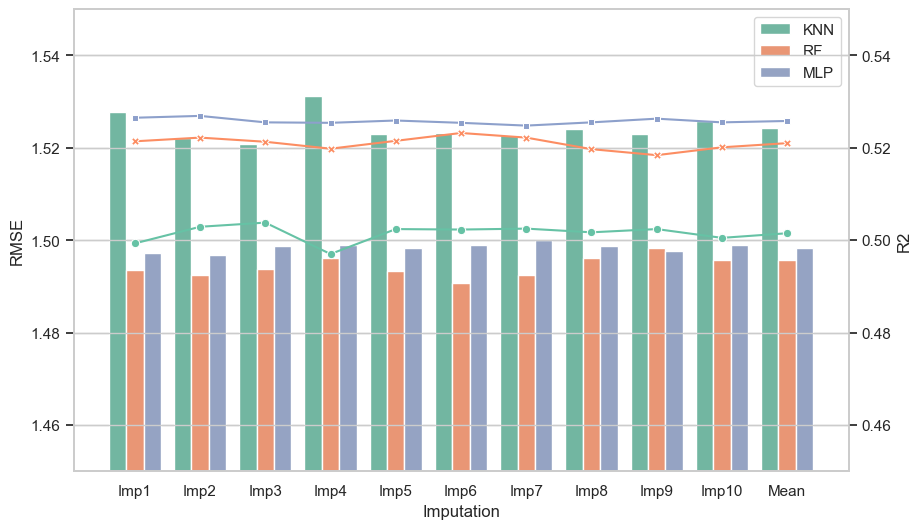

In [530]:
fig, ax1 = plt.subplots(figsize=(10,6))

sns.barplot(x='Imputation', y='RMSE', hue='Model',
            data = data_rmse_long, ax=ax1, palette = 'Set2')
ax1.set_ylim(1.45, 1.55)
ax1.legend(loc='upper right')
ax1.set_ylabel("RMSE")

ax2 = ax1.twinx()
sns.lineplot(x='Imputation', y='R2', hue='Model', style = 'Model',
             data=data_r2_long, ax=ax2, palette = 'Set2', markers=True,
             dashes = False,legend=False)
ax2.set_ylim(0.45, 0.55)
ax2.set_ylabel("R2")

plt.show()

/var/folders/pn/l6kb96rs7vz20qcp8gnx23nw0000gn/T/ipykernel_84491/3729585375.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=final_compare_data, ax=ax1, palette = ["grey", "lightgrey", "lightgrey", "lightgrey"])#palette = 'mako')


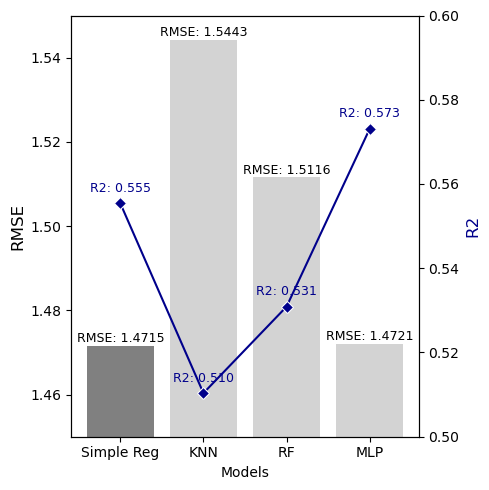

In [154]:
# visualization comparing final models metrics to basic regression model
final_compare_data = pd.DataFrame({
    'Model': ['Simple Reg', 'KNN', 'RF', 'MLP'],
    'RMSE': [1.4714653473885786, 1.5442725258300716, 1.5115502561022531, 1.4721],
    'R2': [0.5554070677684899, 0.5103530678128729, 0.530883908471675, 0.5731]})
sns.color_palette("crest", as_cmap=True)

fig, ax1 = plt.subplots(figsize = (5,5))

sns.barplot(x='Model', y='RMSE', data=final_compare_data, ax=ax1, palette = ["grey", "lightgrey", "lightgrey", "lightgrey"])#palette = 'mako')
ax1.set_xlabel('Models')
ax1.set_ylabel('RMSE', fontsize = 12, color = 'black')
ax1.set_ylim(1.45, 1.55)

for p in ax1.patches:
    height = p.get_height()
    ax1.text(
        p.get_x() + p.get_width()/2,
        height + 0.0002,                # 살짝 위에
        f'RMSE: {height:.4f}',                # 소수점 4자리
        ha='center', va='bottom',
        color='black', fontsize=9
    )

ax2 = ax1.twinx()
sns.lineplot(x='Model', y='R2', data = final_compare_data, ax=ax2,
             color = 'darkblue', marker = 'D')
ax2.set_ylabel('R2', fontsize=12, color = 'darkblue')
ax2.set_ylim(0.5, 0.60)

# line 점 위에 값 쓰기
line = ax2.lines[0]
x_data = line.get_xdata()
y_data = line.get_ydata()

for x, y in zip(x_data, y_data):
    ax2.text(
        x,
        y + 0.002,                       # 점보다 조금 위
        f'R2: {y:.3f}',                      # 소수점 3자리
        ha='center', va='bottom',
        color='darkblue', fontsize=9
    )

# Change axis and tick colors to match the data plots
#ax1.yaxis.label.set_color('darkblue')
#ax2.yaxis.label.set_color('darkorange')
#ax1.tick_params(axis='y', colors='blue')
#ax2.tick_params(axis='y', colors='darkorange')

plt.tight_layout()
             
plt.show()